# Explaining AutoGluon-Tabular Predictions with Kernel SHAP for Classification with Categorical Features

This example uses the original version of <a href="https://archive.ics.uci.edu/ml/datasets/Adult">adult census income dataset</a>, which contains categorical & numerical features. We train an AutoGluon classifier and then explain each of its predictions via [Shapely values](https://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf) that quantify how much each feature contributed to a particular AutoGluon-prediction deviating from some "baseline" value. We use the [Kernel SHAP variant](https://shap.readthedocs.io/en/latest/generated/shap.KernelExplainer.html) which is appropriate for explaining arbitrary black-box models like the potentially heterogeneous ensemble of many models that AutoGluon-Tabular uses to make its predictions.

You must first install the [SHAP package](https://github.com/slundberg/shap/) (`pip install shap`).

**Note:**  Unlike the [similar notebooks](https://shap.readthedocs.io/en/latest/example_notebooks/kernel_explainer/Census%20income%20classification%20with%20scikit-learn.html) from the SHAP package, this example shows you how to apply Kernel SHAP to data with categorical features. In the second half of this notebook, we also demonstrate Shapely values for interpreting predictions in multiclass classification tasks with more than 2 classes.

In [1]:
from autogluon.tabular import TabularDataset, TabularPredictor
import pandas as pd
import numpy as np
import sklearn
import shap

shap.initjs()

import warnings
warnings.filterwarnings('ignore')

Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.


## Load the raw census data

Note these data contain categorical as well as numerical features. We first consider predicting the `class` column, a binary classification task. 

In [2]:
N_SUBSAMPLE = 500  # subsample datasets for faster demo
N_TEST = 50

train_data = TabularDataset('https://autogluon.s3.amazonaws.com/datasets/Inc/train.csv')  # can be local CSV file as well, returns Pandas DataFrame
train_data = train_data.sample(N_SUBSAMPLE)
test_data = TabularDataset('https://autogluon.s3.amazonaws.com/datasets/Inc/test.csv') # another Pandas DataFrame
test_data = test_data.sample(N_TEST)

label = 'class'

y_train = train_data[label]
y_test = test_data[label]
X_train = pd.DataFrame(train_data.drop(columns=[label]))
X_test = pd.DataFrame(test_data.drop(columns=[label]))

display(train_data.head())

Loaded data from: https://autogluon.s3.amazonaws.com/datasets/Inc/train.csv | Columns = 15 / 15 | Rows = 39073 -> 39073
Loaded data from: https://autogluon.s3.amazonaws.com/datasets/Inc/test.csv | Columns = 15 / 15 | Rows = 9769 -> 9769


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
16994,58,Private,317479,HS-grad,9,Divorced,Machine-op-inspct,Not-in-family,Black,Female,0,0,40,United-States,<=50K
6737,22,Private,264874,Some-college,10,Never-married,Tech-support,Other-relative,White,Female,0,0,40,United-States,<=50K
7355,33,Self-emp-not-inc,235271,Bachelors,13,Divorced,Sales,Not-in-family,White,Male,0,0,50,United-States,>50K
11082,39,Private,236648,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,1848,42,United-States,>50K
22945,63,Private,225102,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,?,<=50K


## Train binary classifier using AutoGluon

In [3]:
predictor = TabularPredictor(label=label, problem_type='binary').fit(train_data, time_limit=20)

No path specified. Models will be saved in: AutogluonModels/ag-20201022_074057/
Beginning AutoGluon training ... Time limit = 20s
AutoGluon will save models to AutogluonModels/ag-20201022_074057/
AutoGluon Version:  0.0.15b20201020
Train Data Rows:    500
Train Data Columns: 14
Preprocessing data ...
NumExpr defaulting to 4 threads.
Selected class <--> label mapping:  class 1 =  >50K, class 0 =  <=50K
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    4816.71 MB
	Train Data (Original)  Memory Usage: 0.3 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimiz

### Explain predictions

SHAP is intended to explain how much each feature contributes to a particular prediction. In this binary classification context, "how much" is quantified in terms of the deviation between predicted probability of the positive class from a baseline reference value. Let's first print which `y` value AutoGluon considers to be the "positive" class:

In [4]:
print("positive class:", [label for label in predictor.class_labels if predictor.class_labels_internal_map[label]==1][0])

positive class:  >50K


Next we create a wrapper class around AutoGluon to allow it to be called for prediction inside of the `shap` package:

In [5]:
class AutogluonWrapper:
    def __init__(self, predictor, feature_names):
        self.ag_model = predictor
        self.feature_names = feature_names
    
    def predict_proba(self, X):
        if isinstance(X, pd.Series):
            X = X.values.reshape(1,-1)
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names)
        return self.ag_model.predict_proba(X)    

Next, we define the baseline reference value of the features, which we simply take to be a random sample from the original training dataset here. AutoGluon predictions will be interpreted in terms of their difference from the average prediction across the baseline feature-values (i.e. the prediction for a new datapoint will explained by quantifying how much each feature contributes to this prediction differing from the average prediction over the training data).

In [6]:
baseline = X_train.sample(100) # X_train.mode() could also be reasonable baseline for both numerical/categorical features rather than an entire dataset.

We can now create a `KernelExplainer` which will return Kernel SHAP values to explain particular AutoGluon predictions.

In [7]:
ag_wrapper = AutogluonWrapper(predictor, X_train.columns)
explainer = shap.KernelExplainer(ag_wrapper.predict_proba, baseline)
print("Baseline prediction: ", np.mean(ag_wrapper.predict_proba(baseline)))  # this is the same as explainer.expected_value

NSHAP_SAMPLES = 100  # how many samples to use to approximate each Shapely value, larger values will be slower

Baseline prediction:  0.2701682


Let's first explain a prediction for a single datapoint from the training data.

In [8]:
ROW_INDEX = 0  # index of an example datapoint
single_datapoint = X_train.iloc[[ROW_INDEX]]
single_prediction = ag_wrapper.predict_proba(single_datapoint)

shap_values_single = explainer.shap_values(single_datapoint, nsamples=NSHAP_SAMPLES)
shap.force_plot(explainer.expected_value, shap_values_single, X_train.iloc[ROW_INDEX,:])

num_full_subsets = 1
remaining_weight_vector = [0.25971314 0.18888229 0.15582789 0.13851368 0.12985657 0.12720644]
num_paired_subset_sizes = 6
weight_left = 0.6613591880578676
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 0.9999999999999998
phi = [ 0.          0.          0.         -0.01535406 -0.01990304 -0.1450361
 -0.01321664 -0.01686422  0.         -0.01485853 -0.00825825  0.
  0.          0.        ]


We can also plot Kernel SHAP explanations aggregated across many predictions, say over all the datapoints in the test data.

In [9]:
shap_values = explainer.shap_values(X_test, nsamples=NSHAP_SAMPLES)
shap.force_plot(explainer.expected_value, shap_values, X_test)

num_full_subsets = 1
remaining_weight_vector = [0.25971314 0.18888229 0.15582789 0.13851368 0.12985657 0.12720644]
num_paired_subset_sizes = 6
weight_left = 0.6613591880578676
np.sum(w_aug) = 13.999999999999998
np.sum(self.kernelWeights) = 1.0
phi = [ 0.01335915  0.         -0.01923869  0.05963148  0.094806   -0.15334044
  0.05425469 -0.03344013  0.          0.03298006 -0.01645236  0.
  0.0446236   0.        ]
num_full_subsets = 1
remaining_weight_vector = [0.25971314 0.18888229 0.15582789 0.13851368 0.12985657 0.12720644]
num_paired_subset_sizes = 6
weight_left = 0.6613591880578676
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [0.02032992 0.         0.01914735 0.05611307 0.12065368 0.16089978
 0.06225421 0.         0.         0.         0.1093361  0.01626573
 0.06264629 0.01550022]
num_full_subsets = 1
remaining_weight_vector = [0.25971314 0.18888229 0.15582789 0.13851368 0.12985657 0.12720644]
num_paired_subset_sizes = 6
weight_left = 0.6613591880578676
np.sum(w_aug) = 

remaining_weight_vector = [0.25971314 0.18888229 0.15582789 0.13851368 0.12985657 0.12720644]
num_paired_subset_sizes = 6
weight_left = 0.6613591880578676
np.sum(w_aug) = 13.999999999999998
np.sum(self.kernelWeights) = 1.0
phi = [ 0.          0.         -0.00904696 -0.02136332 -0.03162716 -0.10703681
 -0.03448125 -0.01597352  0.          0.         -0.00294395  0.
  0.          0.        ]
num_full_subsets = 1
remaining_weight_vector = [0.25971314 0.18888229 0.15582789 0.13851368 0.12985657 0.12720644]
num_paired_subset_sizes = 6
weight_left = 0.6613591880578676
np.sum(w_aug) = 13.999999999999996
np.sum(self.kernelWeights) = 0.9999999999999998
phi = [-0.01996663  0.          0.         -0.02476461 -0.021367   -0.11115531
 -0.02950365 -0.01845035  0.          0.         -0.01042935  0.
  0.          0.        ]
num_full_subsets = 1
remaining_weight_vector = [0.25971314 0.18888229 0.15582789 0.13851368 0.12985657 0.12720644]
num_paired_subset_sizes = 6
weight_left = 0.6613591880578676
np

num_full_subsets = 1
remaining_weight_vector = [0.25971314 0.18888229 0.15582789 0.13851368 0.12985657 0.12720644]
num_paired_subset_sizes = 6
weight_left = 0.6613591880578676
np.sum(w_aug) = 13.999999999999998
np.sum(self.kernelWeights) = 0.9999999999999998
phi = [ 0.          0.          0.         -0.02193424 -0.03238148 -0.10986601
 -0.03457154 -0.01746877  0.          0.          0.          0.
 -0.00995861  0.        ]
num_full_subsets = 1
remaining_weight_vector = [0.25971314 0.18888229 0.15582789 0.13851368 0.12985657 0.12720644]
num_paired_subset_sizes = 6
weight_left = 0.6613591880578676
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [ 0.01562448  0.          0.         -0.01599129  0.14930069 -0.16553519
 -0.0263742  -0.02365729  0.          0.02198299 -0.01225923  0.
  0.07373065  0.        ]
num_full_subsets = 1
remaining_weight_vector = [0.25971314 0.18888229 0.15582789 0.13851368 0.12985657 0.12720644]
num_paired_subset_sizes = 6
weight_left = 0.661359188057

A summary plot is an even better way to see the relative impact of all features over many datapoints. Features are sorted by the sum of their SHAP value magnitudes across all samples.

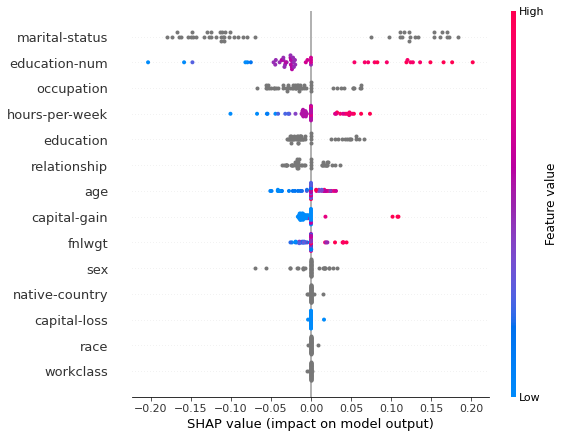

In [10]:
shap.summary_plot(shap_values, X_test)

A dependence plot can be used to visualize how the number of years of education increases the chance of making over 50K annually.

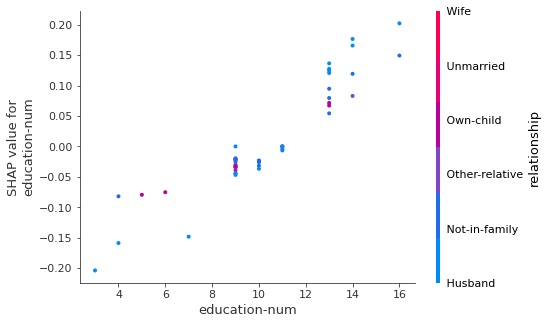

In [11]:
shap.dependence_plot("education-num", shap_values, X_test)

## Scoring Overall Feature Importance via Permutation Shuffling

Note that if you'd like to understand how much each feature contributes to AutoGluon's general predictive accuracy (rather than explaining individual predictions), AutoGluon offers a built-in method for this based on [permutation-shuffling](https://explained.ai/rf-importance/):

In [12]:
predictor.feature_importance(test_data)

Computing raw permutation importance for 14 features on weighted_ensemble_k0_l1 ...
	1.02s	= Expected runtime
	0.64s	= Actual runtime


marital-status    0.02
native-country    0.00
hours-per-week    0.00
capital-loss      0.00
capital-gain      0.00
sex               0.00
race              0.00
relationship      0.00
education         0.00
fnlwgt            0.00
workclass         0.00
age               0.00
occupation       -0.02
education-num    -0.04
dtype: float64

Features with near zero or negative importance score above hardly contribute at all to AutoGluon's overall accuracy on the test data, whereas features near the top of this list contain the most predictive signal.

# Multiclass Classification

Let's now repeat this same analysis for a multiclass classification problem with more than 2 classes. We'll use the same dataset and predict the `relationship` variable based on the other columns' values. For interpreting predictions in multiclass classification, SHAP will quantify how much each feature contributes to the predicted probability for each class separately.

In [13]:
label = 'relationship'

y_train = train_data[label]
y_test = test_data[label]
X_train = pd.DataFrame(train_data.drop(columns=[label]))
X_test = pd.DataFrame(test_data.drop(columns=[label]))

display(train_data.head())
print("Possible classes: \n", train_data[label].value_counts())

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
16994,58,Private,317479,HS-grad,9,Divorced,Machine-op-inspct,Not-in-family,Black,Female,0,0,40,United-States,<=50K
6737,22,Private,264874,Some-college,10,Never-married,Tech-support,Other-relative,White,Female,0,0,40,United-States,<=50K
7355,33,Self-emp-not-inc,235271,Bachelors,13,Divorced,Sales,Not-in-family,White,Male,0,0,50,United-States,>50K
11082,39,Private,236648,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,1848,42,United-States,>50K
22945,63,Private,225102,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,?,<=50K


Possible classes: 
  Husband           202
 Not-in-family     132
 Own-child          68
 Unmarried          51
 Wife               25
 Other-relative     22
Name: relationship, dtype: int64


Fit an AutoGluon classifier:

In [14]:
predictor_multi = TabularPredictor(label=label, problem_type='multiclass').fit(train_data, time_limit=20)

No path specified. Models will be saved in: AutogluonModels/ag-20201022_074120/
Beginning AutoGluon training ... Time limit = 20s
AutoGluon will save models to AutogluonModels/ag-20201022_074120/
AutoGluon Version:  0.0.15b20201020
Train Data Rows:    500
Train Data Columns: 14
Preprocessing data ...
Train Data Class Count: 6
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    4747.96 MB
	Train Data (Original)  Memory Usage: 0.29 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerat

Note that now the baseline predicted value is now a vector of predicted probabilities (for each class). For a particular prediction, SHAP will produce a separate set of Shapely values for each class, which quantify how much each feature contributes the particular prediction deviating from the baseline probability value for that class. 

In [15]:
baseline = X_train.sample(100) # X_train.mode() could also be reasonable baseline for both numerical/categorical features rather than an entire dataset.

ag_wrapper = AutogluonWrapper(predictor_multi, X_train.columns)
explainer = shap.KernelExplainer(ag_wrapper.predict_proba, baseline)
print("Baseline prediction: \n", pd.DataFrame(np.mean(ag_wrapper.predict_proba(baseline),axis=0,keepdims=True), columns=predictor_multi.class_labels))  # this is the same as explainer.expected_value

NSHAP_SAMPLES = 100  # how many samples to use to approximate each Shapely value, larger values will be slower
shap.initjs()

Baseline prediction: 
     Husband   Not-in-family   Other-relative   Own-child   Unmarried      Wife
0  0.432849        0.264093         0.040288    0.099452    0.117331  0.045987


Again we can compute the Shapely values for an individual prediction. Note that some SHAP functions like `force_plot`, `dependence_plot` will not work in this multiclass setting, as they can only operate with a single set of Shapely values. For these plots, we will thus only focus on the Shapely values corresponding to one class of interest. 

In [21]:
ROW_INDEX = 0  # index of an example datapoint
class_of_interest = ' Not-in-family'  # can be any value in set(y_train)
class_index = predictor_multi.class_labels.index(class_of_interest)

single_datapoint = X_train.iloc[[ROW_INDEX]]
single_prediction = ag_wrapper.predict_proba(single_datapoint)

shap_values_single = explainer.shap_values(single_datapoint, nsamples=NSHAP_SAMPLES)
print("Shapely values: \n", {predictor_multi.class_labels[i]:shap_values_single[i] for i in range(len(predictor_multi.class_labels))})

print(f"Force_plot for class: {class_of_interest}")
shap.force_plot(explainer.expected_value[class_index], shap_values_single[class_index], X_train.iloc[ROW_INDEX,:])

num_full_subsets = 1
remaining_weight_vector = [0.25971314 0.18888229 0.15582789 0.13851368 0.12985657 0.12720644]
num_paired_subset_sizes = 6
weight_left = 0.6613591880578676
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 0.9999999999999998
phi = [ 0.          0.          0.          0.          0.         -0.17242191
  0.          0.         -0.19656318  0.          0.          0.
  0.         -0.02079062]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 0.9999999999999998
phi = [0.07913836 0.         0.05335287 0.         0.         0.18310323
 0.0603866  0.         0.         0.         0.         0.
 0.         0.0249798 ]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 0.9999999999999998
phi = [ 0.          0.         -0.00581648 -0.00204271  0.          0.
 -0.01192157 -0.01124871  0.02014581  0.          0.          0.
  0.          0.        ]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 0.9999999999999998
phi = [-0.04868437  0.         -0.0106945   0.          0.  


Shapely values: 
 {' Husband': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.17242191,  0.        ,  0.        , -0.19656318,  0.        ,
         0.        ,  0.        ,  0.        , -0.02079062]]), ' Not-in-family': array([[0.07913836, 0.        , 0.05335287, 0.        , 0.        ,
        0.18310323, 0.0603866 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.0249798 ]]), ' Other-relative': array([[ 0.        ,  0.        , -0.00581648, -0.00204271,  0.        ,
         0.        , -0.01192157, -0.01124871,  0.02014581,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ]]), ' Own-child': array([[-0.04868437,  0.        , -0.0106945 ,  0.        ,  0.        ,
        -0.01891853,  0.        ,  0.        , -0.00538712,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ]]), ' Unmarried': array([[-0.02416748,  0.        , -0.01812214,  0.        ,  0.        ,
        

**Note:** If you see message "Visualization omitted, Javascript library not loaded", simply re-running the corresponding cells should show the plots. 

Next we again plot aggregated Shapely values for predictions for every datapoint in the test data (for the class of interest), as well as a summary_plot, and dependence_plot (for the class of interest, as well as a particular feature of interest).

In [22]:
shap_values = explainer.shap_values(X_test, nsamples=NSHAP_SAMPLES)

print(f"Force_plot for class: {class_of_interest}")
shap.force_plot(explainer.expected_value[class_index], shap_values[class_index], X_test)

num_full_subsets = 1
remaining_weight_vector = [0.25971314 0.18888229 0.15582789 0.13851368 0.12985657 0.12720644]
num_paired_subset_sizes = 6
weight_left = 0.6613591880578676
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [ 0.          0.         -0.04363579  0.          0.         -0.35391024
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [0.0235418  0.         0.05157089 0.         0.02026401 0.27985895
 0.         0.         0.0553467  0.         0.         0.04057156
 0.         0.        ]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [ 0.          0.         -0.00618978 -0.00363265 -0.01269148  0.01359264
 -0.00341112 -0.00123526 -0.01153994  0.          0.          0.
  0.         -0.000982  ]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [-0.03820684  0.          0.01632758  0.         -0.01603227  0.05589055
  0.01600584  0.         

np.sum(self.kernelWeights) = 1.0
phi = [0.         0.         0.         0.         0.         0.28165671
 0.         0.         0.15687524 0.         0.         0.
 0.         0.03895265]
np.sum(w_aug) = 13.999999999999998
np.sum(self.kernelWeights) = 1.0
phi = [ 0.          0.          0.          0.          0.         -0.19588959
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
np.sum(w_aug) = 13.999999999999998
np.sum(self.kernelWeights) = 1.0
phi = [-0.00325705  0.         -0.00346153  0.          0.         -0.01140967
  0.          0.         -0.02275382  0.          0.          0.
  0.          0.00794834]
np.sum(w_aug) = 13.999999999999998
np.sum(self.kernelWeights) = 1.0
phi = [-0.02277726  0.         -0.00943582  0.          0.         -0.0466165
  0.          0.          0.          0.          0.          0.
  0.         -0.01802125]
np.sum(w_aug) = 13.999999999999998
np.sum(self.kernelWeights) = 1.0
phi = [ 0.          0.        

np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 0.9999999999999998
phi = [ 0.          0.         -0.00612811 -0.00471336 -0.01118669  0.01620521
 -0.00701673  0.         -0.01379965  0.          0.          0.
  0.          0.        ]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 0.9999999999999998
phi = [-0.03499281  0.          0.          0.         -0.01710521  0.05817714
 -0.0153781   0.          0.          0.          0.          0.
  0.          0.        ]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 0.9999999999999998
phi = [ 0.          0.         -0.01986382  0.         -0.00501772  0.01284524
  0.          0.         -0.06392024  0.          0.          0.
  0.          0.00723389]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 0.9999999999999998
phi = [ 0.          0.         -0.00276816  0.          0.         -0.01179293
  0.          0.         -0.02354997  0.          0.          0.
  0.         -0.00201802]
num_full_subsets = 1
remaining_weight_vector

np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [-0.02380942 -0.00810337 -0.0085175   0.          0.         -0.05401402
  0.          0.         -0.00244725  0.          0.          0.
  0.          0.        ]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [ 0.         -0.01058291 -0.01132273  0.          0.         -0.0500162
  0.          0.         -0.04292572  0.          0.          0.
  0.          0.        ]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [ 0.          0.          0.          0.          0.          0.06015992
  0.          0.         -0.10080049  0.          0.          0.
  0.          0.        ]
num_full_subsets = 1
remaining_weight_vector = [0.25971314 0.18888229 0.15582789 0.13851368 0.12985657 0.12720644]
num_paired_subset_sizes = 6
weight_left = 0.6613591880578676
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [ 0.          0.          0.          0.          0.         -0.30678945
  0.          0.    

np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0000000000000002
phi = [ 0.0131153   0.         -0.0288084   0.          0.          0.044215
  0.          0.         -0.09281115  0.          0.          0.
  0.          0.        ]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0000000000000002
phi = [ 0.         -0.00092179  0.01766065  0.          0.         -0.01059858
  0.          0.         -0.0204769   0.          0.          0.
  0.         -0.00334355]
num_full_subsets = 1
remaining_weight_vector = [0.25971314 0.18888229 0.15582789 0.13851368 0.12985657 0.12720644]
num_paired_subset_sizes = 6
weight_left = 0.6613591880578676
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [ 0.          0.          0.          0.          0.         -0.38484765
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [-0.03551522  0.         -0.02482814 -0.02910054 -0.04577638  0.

num_full_subsets = 1
remaining_weight_vector = [0.25971314 0.18888229 0.15582789 0.13851368 0.12985657 0.12720644]
num_paired_subset_sizes = 6
weight_left = 0.6613591880578676
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 0.9999999999999998
phi = [ 0.          0.          0.          0.          0.         -0.13452797
  0.          0.         -0.19000713  0.          0.          0.
  0.          0.        ]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 0.9999999999999998
phi = [ 0.          0.          0.          0.          0.          0.19740237
  0.         -0.01735492 -0.08555757  0.          0.          0.
  0.         -0.0380706 ]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 0.9999999999999998
phi = [0.         0.         0.02714827 0.         0.         0.0280214
 0.00930943 0.         0.05120726 0.         0.         0.
 0.         0.02323136]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 0.9999999999999998
phi = [-0.03905844 -0.00278393 -0.01421009  0.       

phi = [ 0.          0.          0.          0.          0.         -0.30327198
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [ 0.          0.         -0.04300357  0.          0.          0.28222298
  0.          0.          0.07104261  0.          0.          0.
  0.          0.03157288]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [ 0.          0.00378219  0.00196067  0.         -0.00387055  0.011083
 -0.00811463  0.         -0.01020887  0.          0.          0.00307317
  0.          0.00173861]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [-0.03941324  0.          0.03242371 -0.00741236  0.         -0.02114778
  0.02199958  0.          0.01091372  0.          0.          0.00447336
  0.          0.        ]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [ 0.01104039  0.          0.          0.          0.          0.07089132
  0.       

np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [0.         0.         0.         0.         0.         0.33416977
 0.         0.         0.11511055 0.         0.         0.
 0.         0.        ]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [-0.00226826 -0.00032465 -0.0037206   0.         -0.00261282  0.
 -0.00057343  0.         -0.01261085  0.          0.          0.
  0.          0.        ]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [-0.03329561  0.00315135  0.00521115  0.          0.         -0.03385536
  0.01303539  0.          0.          0.01867104  0.          0.
  0.          0.00579575]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [ 0.01262047  0.          0.          0.          0.          0.04556849
  0.          0.         -0.10406549  0.          0.          0.
  0.          0.        ]
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [ 0.          0.         -0.00291068  0.          0.         -0.00

np.sum(w_aug) = 13.999999999999998
np.sum(self.kernelWeights) = 0.9999999999999998
phi = [-0.02571257 -0.01036348  0.0316543   0.          0.         -0.00649424
  0.          0.          0.          0.          0.         -0.01941787
  0.          0.        ]
np.sum(w_aug) = 13.999999999999998
np.sum(self.kernelWeights) = 0.9999999999999998
phi = [ 0.         -0.01096757  0.          0.          0.          0.05154118
  0.          0.         -0.07912938  0.          0.         -0.01040858
  0.          0.        ]
np.sum(w_aug) = 13.999999999999998
np.sum(self.kernelWeights) = 0.9999999999999998
phi = [ 0.          0.00488901 -0.00477501  0.          0.00460322 -0.00903074
 -0.00155     0.         -0.02392946  0.         -0.00158579 -0.00167037
  0.         -0.00375561]
num_full_subsets = 1
remaining_weight_vector = [0.25971314 0.18888229 0.15582789 0.13851368 0.12985657 0.12720644]
num_paired_subset_sizes = 6
weight_left = 0.6613591880578676
np.sum(w_aug) = 13.999999999999998
np.sum

phi = [-0.0247395   0.00635078  0.01136743  0.          0.         -0.05929402
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
np.sum(w_aug) = 13.999999999999996
np.sum(self.kernelWeights) = 0.9999999999999998
phi = [ 0.          0.         -0.01011694  0.          0.         -0.05332318
  0.          0.         -0.04576979  0.          0.          0.
  0.          0.        ]
np.sum(w_aug) = 13.999999999999996
np.sum(self.kernelWeights) = 0.9999999999999998
phi = [ 0.          0.          0.          0.          0.          0.07016469
  0.          0.         -0.10429581  0.          0.          0.
  0.          0.        ]
num_full_subsets = 1
remaining_weight_vector = [0.25971314 0.18888229 0.15582789 0.13851368 0.12985657 0.12720644]
num_paired_subset_sizes = 6
weight_left = 0.6613591880578676
np.sum(w_aug) = 14.0
np.sum(self.kernelWeights) = 1.0
phi = [ 0.          0.          0.          0.          0.          0.11643603
  0.          0


Force_plot for class:  Not-in-family


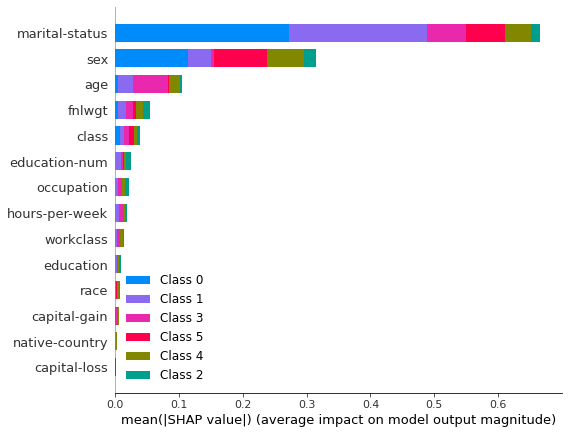

{'Class 0': ' Husband', 'Class 1': ' Not-in-family', 'Class 2': ' Other-relative', 'Class 3': ' Own-child', 'Class 4': ' Unmarried', 'Class 5': ' Wife'}


In [23]:
shap.summary_plot(shap_values, X_test)
print({"Class "+str(i) : predictor_multi.class_labels[i] for i in range(len(predictor_multi.class_labels))})

Dependence_plot for class:  Not-in-family  and for feature: marital-status 



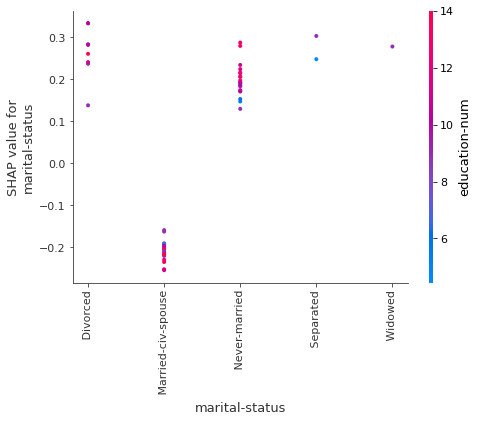

In [27]:
dependence_feature = "marital-status"
print(f"Dependence_plot for class: {class_of_interest}  and for feature: {dependence_feature} \n")

shap.dependence_plot(dependence_feature, shap_values[class_index], X_test)

For multiclass problems, we can still score overall feature importance using AutoGluon's built-in procedure:

In [28]:
predictor.feature_importance(test_data)

Computing raw permutation importance for 14 features on weighted_ensemble_k0_l1 ...
	1.18s	= Expected runtime
	0.83s	= Actual runtime


marital-status    0.02
native-country    0.00
hours-per-week    0.00
capital-loss      0.00
capital-gain      0.00
sex               0.00
race              0.00
relationship      0.00
education         0.00
fnlwgt            0.00
workclass         0.00
age               0.00
occupation       -0.02
education-num    -0.04
dtype: float64